- **ML_PRO -  Modul1  - Projet Bank Churn**

- **Avril 2025**

# Identify the problem and search a global vision

- **Objectif:**  Prédire si un client va continuer à utiliser les services de la banque **OU** il va clôturer son compte
- **Problem:** Supervised learning - Binary Classification - Offline
- **Metrics:** Score F1

**Fondamental Analysis**


**Form analysis**
- *Identify the target:* Exited
- *Number of the rows and columns:* (143579, 12)
- *Type of variables:* 3 Categorical, 9 Numerics
- *Identify missing values:* No missing values

**Content analysis**
- *Visualize the target:* Binaire (0/1) => (21% résiliés & 79% Non résiliés)
- *Understand the different variables:*
    - Les échelles des variables sont très différentes

- *Visualize features-target relationships:* 
    - Age/target : Il semble que les personnes les plus agées sont celles qui résilient leur compte bancaire > Hypothèse à tester!
- *Identify outliers:* 

**Initial Conclusions**
- Presque pas de variables "descriminante" pour destinguer les cas des clients resiliés Oui/Non, ce qui nous permet de dire qu'il n'est pas vraiment approprie de vouloir prédire si un client va clôturer ou non son compte bancaire en se basant sur ces données. Mais on va aller au bout des choses ! 


**Null hypotheses - H0**


# Libraries

In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

# Get Data

In [116]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

In [8]:
df_train.head(1)

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,37765,15794860,Ch'eng,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0


In [9]:
df_test.head(1)

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,67897,15585246,Bancks,585,France,Female,53.0,2,0.0,2,1.0,1.0,91830.75


In [117]:
# Supprimer les colonnes inutiles pour cette analyse
col_delete = ["CustomerId", "Surname"]
df = df_train.drop(columns=col_delete)
df_test.drop(columns=col_delete, inplace=True)

# I. Preliminary data analysis

## Form analysis

In [11]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143579 entries, 0 to 143578
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      143579 non-null  int64  
 1   Geography        143579 non-null  object 
 2   Gender           143579 non-null  object 
 3   Age              143579 non-null  float64
 4   Tenure           143579 non-null  int64  
 5   Balance          143579 non-null  float64
 6   NumOfProducts    143579 non-null  int64  
 7   HasCrCard        143579 non-null  float64
 8   IsActiveMember   143579 non-null  float64
 9   EstimatedSalary  143579 non-null  float64
 10  Exited           143579 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 12.0+ MB


In [13]:
df.dtypes.value_counts()

float64    5
int64      4
object     2
Name: count, dtype: int64

In [14]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Content analysis

### Numeric variables

In [15]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,143579.000000,143579.000000,143579.000000,143579.000000,143579.000000,143579.000000,143579.000000,143579.000000,143579.000000
mean,656.411704,38.144476,5.018408,55533.640642,1.553932,0.754107,0.496800,112530.072465,0.212078
std,80.210361,8.871711,2.807027,62822.616346,0.546754,0.430617,0.499991,50301.718378,0.408781
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74580.800000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117931.100000,0.000000
75%,710.000000,42.000000,7.000000,119948.090000,2.000000,1.000000,1.000000,155149.685000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


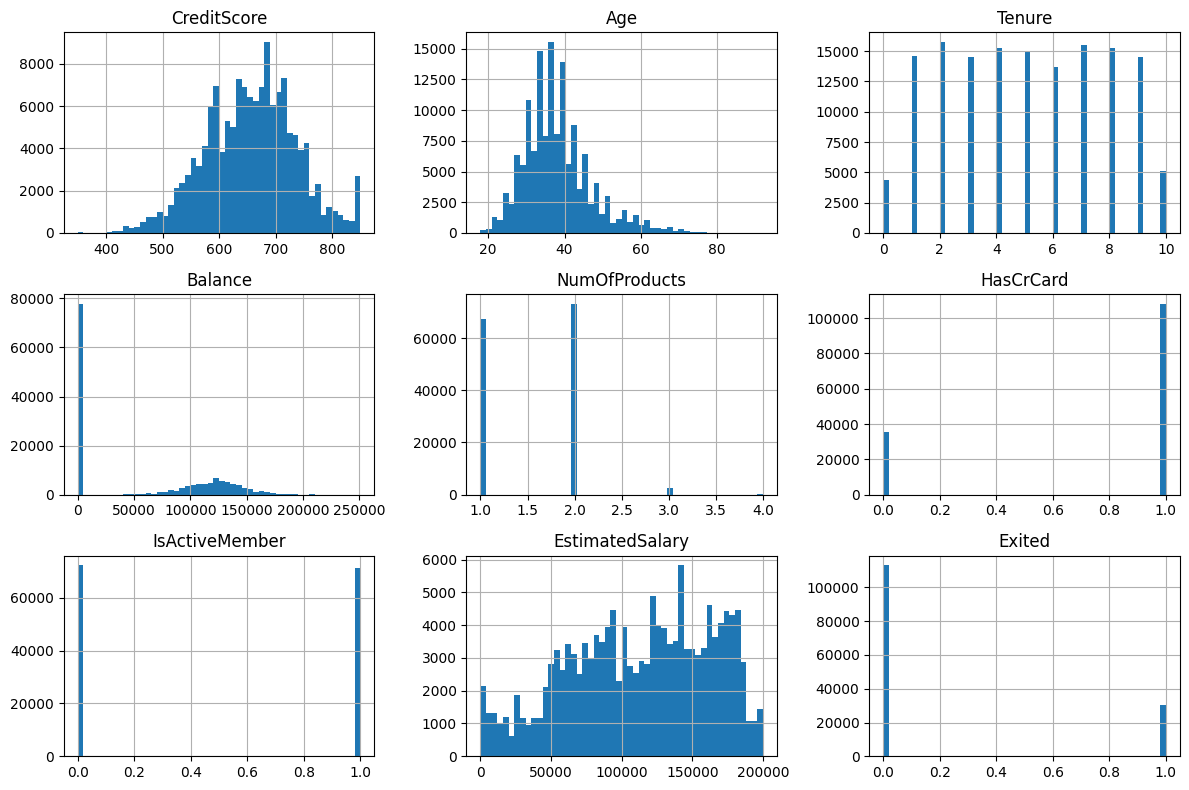

In [16]:
df.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [17]:
df["Exited"].value_counts(normalize=True)

Exited
0    0.787922
1    0.212078
Name: proportion, dtype: float64

### Categorical variable

In [18]:
for col in df.select_dtypes(include="object"):
    print(f"{col :-<20} {df[col].unique()}")

Geography----------- ['France' 'Germany' 'Spain']
Gender-------------- ['Male' 'Female']


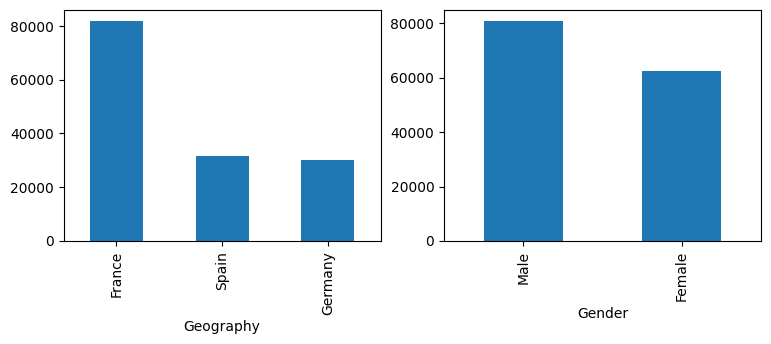

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
df["Geography"].value_counts().plot(kind="bar", ax=ax[0])
df["Gender"].value_counts().plot(kind="bar", ax=ax[1])
plt.show()

# II. Exploratory Data Analysis - EDA

## Correlation

In [20]:
# Heat map
def get_corr_matrix_and_heatmap(df):
    # Calculate correlation
    corr_matrix = df.corr(numeric_only=True)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    # Set up the matplotlib figure
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot the correlation matrix
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, square=True, ax=ax)
    return corr_matrix, fig

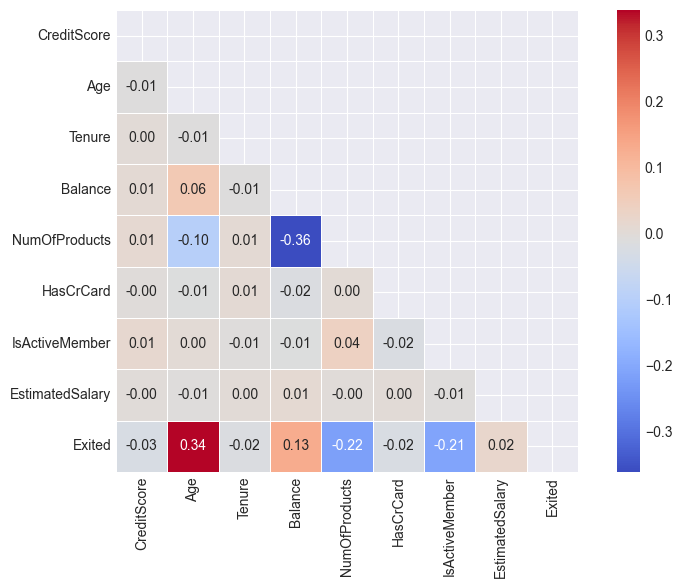

In [21]:
corr_matrix, fig = get_corr_matrix_and_heatmap(df)

In [22]:
corr_matrix["Exited"].sort_values(ascending=False)

Exited             1.000000
Age                0.339086
Balance            0.130686
EstimatedSalary    0.019389
Tenure            -0.019335
HasCrCard         -0.022615
CreditScore       -0.026925
IsActiveMember    -0.210749
NumOfProducts     -0.216772
Name: Exited, dtype: float64

**Target -  Age**

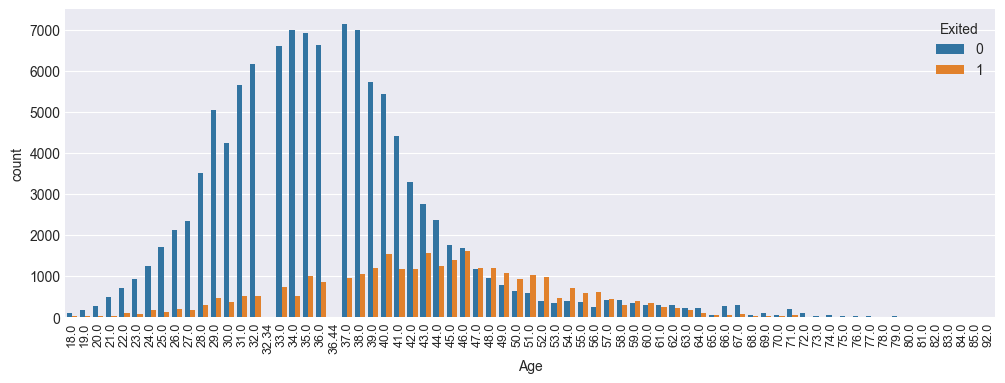

In [23]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x="Age", hue="Exited")
plt.xticks(rotation=90, fontsize=9)
plt.show()


**Target - Variable catégirielles**

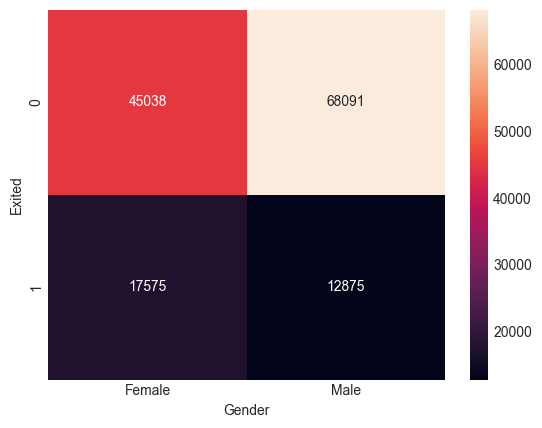

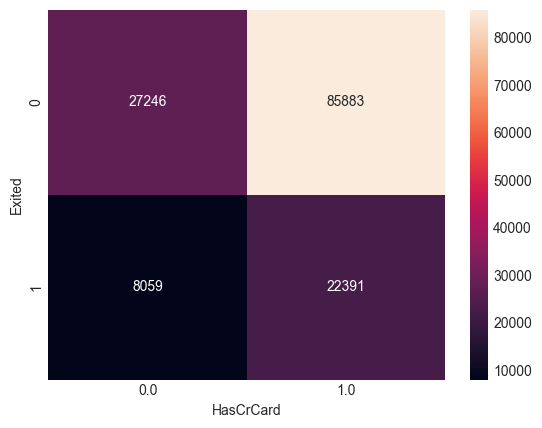

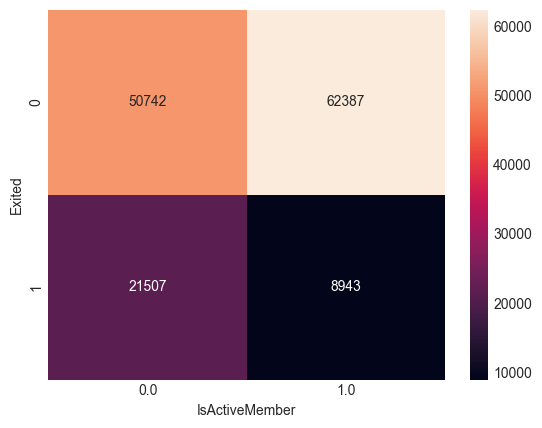

In [24]:
cat_var = ["Gender", "HasCrCard", "IsActiveMember"]
for col in cat_var:
    plt.figure()
    sns.heatmap(pd.crosstab(df["Exited"], df[col]), annot=True, fmt="d")

# III. Preprocessing

In [25]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


In [26]:
X = df.drop("Exited", axis=1)
y= df["Exited"]

In [184]:
columntransformer = ColumnTransformer([
    ("OneHotEncoder", OneHotEncoder(), ["Geography", "Gender"]),
    ("MinMaxEncoder",
     make_pipeline(MinMaxScaler(), PolynomialFeatures(3, include_bias=False)),
     ["CreditScore", "Age","Tenure", "Balance", "EstimatedSalary", "NumOfProducts", "HasCrCard", "IsActiveMember"]),
],
remainder="passthrough",
)

# Pipeline de preprocessing nommé
preprocessing = Pipeline([
    ("columntransformer", columntransformer),
    ("selectk", SelectKBest(score_func=f_classif, k=20))
])

preprocessing

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  ['Geography', 'Gender']),
                                                 ('MinMaxEncoder',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember'])])),
                ('selectk', SelectKBest(k=20))])

In [193]:
# Transformation des données
df_prep = preprocessing.fit_transform(X, y)

# Récupérer les noms des colonnes transformées
columns_transformed = preprocessing.named_steps['columntransformer'].get_feature_names_out()

# Créer un DataFrame avec les données transformées
# Appliquer SelectKBest et récupérer les colonnes sélectionnées
mask_selected = preprocessing.named_steps['selectk'].get_support()
selected_columns = columns_transformed[mask_selected]

# Créer le DataFrame avec les colonnes sélectionnées
df_prep = pd.DataFrame(df_prep, columns=selected_columns)

# Affichage du DataFrame final
df_prep.columns


Index(['OneHotEncoder__Geography_Germany', 'MinMaxEncoder__Age',
       'MinMaxEncoder__NumOfProducts', 'MinMaxEncoder__IsActiveMember',
       'MinMaxEncoder__CreditScore Age', 'MinMaxEncoder__Age^2',
       'MinMaxEncoder__Age Balance', 'MinMaxEncoder__Age EstimatedSalary',
       'MinMaxEncoder__IsActiveMember^2', 'MinMaxEncoder__CreditScore Age^2',
       'MinMaxEncoder__CreditScore Age Balance',
       'MinMaxEncoder__CreditScore Age EstimatedSalary',
       'MinMaxEncoder__Age^3', 'MinMaxEncoder__Age^2 Tenure',
       'MinMaxEncoder__Age^2 Balance', 'MinMaxEncoder__Age^2 EstimatedSalary',
       'MinMaxEncoder__Age^2 HasCrCard', 'MinMaxEncoder__Age Balance^2',
       'MinMaxEncoder__Age Balance EstimatedSalary',
       'MinMaxEncoder__IsActiveMember^3'],
      dtype='object')

# IV. Modelisation

In [190]:
RandomForest = make_pipeline(preprocessing, RandomForestClassifier(random_state=42))
AdaBoost = make_pipeline(preprocessing, AdaBoostClassifier(random_state=42))
SVM = make_pipeline(preprocessing, SVC(random_state=42))
KNN = make_pipeline(preprocessing, KNeighborsClassifier())
DTree = make_pipeline(preprocessing, DecisionTreeClassifier())
LogR = make_pipeline(preprocessing, LogisticRegression())
Gauss = make_pipeline(preprocessing, GaussianNB())

In [57]:
models = {
    'RandomForest': RandomForest,
    'AdaBoost': AdaBoost,
    'LogR': LogR,
    'KNN': KNN,
    'DTree': DTree,
    'Gauss': Gauss
    }

# V. Evaluation

In [191]:
def evaluation(model, X, y):
    # Score F1 moyen avec validation croisée
    scores = cross_val_score(model, X, y, scoring="f1", cv=3)
    print("Score F1 moyen :", round(scores.mean(), 4))

In [192]:
for name, model in models.items():
    print(name)
    evaluation(model, X, y)

RandomForest
Score F1 moyen : 0.6147
AdaBoost
Score F1 moyen : 0.6272
LogR
Score F1 moyen : 0.6217
KNN
Score F1 moyen : 0.6008
DTree
Score F1 moyen : 0.53
Gauss
Score F1 moyen : 0.4341


StandardScaler
RandomForest
Score F1 moyen : 0.6147
AdaBoost
Score F1 moyen : 0.6272
LogR
Score F1 moyen : 0.6217
KNN
Score F1 moyen : 0.6008
DTree
Score F1 moyen : 0.5302
Gauss
Score F1 moyen : 0.4341

# VI. Optimisation

In [91]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("classifier", AdaBoostClassifier())
])
# Paramètres à optimiser
param_distributions = {
    "preprocessing__selectk__k": np.arange(13, 30),
    "classifier__n_estimators": np.arange(150, 501, 50),
    "classifier__learning_rate": [0.1, 0.5, 1.0, 2.0]
}

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rnd_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)


rnd_search.fit(X, y)

print("Meilleurs paramètres :", rnd_search.best_params_)
print("Meilleur F1-score    :", rnd_search.best_score_)

Meilleurs paramètres : {'preprocessing__selectk__k': np.int64(25), 'classifier__n_estimators': np.int64(350), 'classifier__learning_rate': 1.0}
Meilleur F1-score    : 0.6312168261364609


k = 15
Meilleurs paramètres : {'preprocessing__selectk__k': np.int64(15)}
Meilleur F1-score    : 0.6304160492998837

k=15, n=150
Meilleurs paramètres : {'classifier__n_estimators': np.int64(150)}
Meilleur F1-score    : 0.631336610550887

Meilleurs paramètres : {'classifier__learning_rate': 1.0}
Meilleur F1-score    : 0.631336610550887



In [104]:
# Pipeline complet avec RandomForest
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("classifier", RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, max_features=None))
])

# Hyperparamètres à tester
param_distributions = {
    "preprocessing__selectk__k": np.arange(5, 30),
    #"classifier__n_estimators": [50, 100, 200, 300, 500],
    #"classifier__max_depth": [None, 5, 10, 20, 30],
    #"classifier__max_features": ['sqrt', 'log2', None]
}

# RandomizedSearchCV
rnd_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="f1",
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Entraînement
rnd_search.fit(X, y)

# Résultats
print("Meilleurs paramètres :", rnd_search.best_params_)
print("Meilleur F1-score    :", rnd_search.best_score_)


/Users/mouloud/Library/Caches/pypoetry/virtualenvs/ml-pro-g7iKP5WX-py3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=30. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs paramètres : {'preprocessing__selectk__k': np.int64(20)}
Meilleur F1-score    : 0.635252503574249


Meilleurs paramètres : {'classifier__max_features': None}
Meilleur F1-score    : 0.6329178846996204

In [ ]:
final_model = rnd_search.best_estimator_

In [106]:
final_model.fit(X, y) # type: ignore

/Users/mouloud/Library/Caches/pypoetry/virtualenvs/ml-pro-g7iKP5WX-py3.12/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('OneHotEncoder',
                                                                   OneHotEncoder(),
                                                                   ['Geography',
                                                                    'Gender']),
                                                                  ('StandardScaler',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler()),
                                                                                   ('polynomialfeatures',
                                                                                    PolynomialFeatures(include_bias=False))]),
                                                                   ['CreditScore',
                                                                    'Age',
                                                                    'Tenure',
                                                                    'Balance',
                                                                    'EstimatedSalary',
                                                                    'NumOfProducts'])])),
                                 ('selectk', SelectKBest(k=np.int64(20)))])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        random_state=42))])

In [ ]:
final_predictions = final_model.predict(df_test) # type: ignore

# VI. Submit Predictions

In [119]:
final_predictions

array([0, 0, 1, ..., 0, 1, 0], shape=(21455,))

In [121]:
submissions = pd.DataFrame()
submissions["Exited"] = final_predictions
submissions["ID"] = df_test["ID"]
submissions = submissions.set_index("ID")
submissions

,Exited
ID,
67897,0
163075,0
134760,1
68707,0
3428,0
...,...
24790,0
152608,1
28134,0


In [122]:
submissions.to_csv("submission.csv")